# CoronaVirus Pandemic: EDA for core pandemic metrics

This notebook is focused on

- exhaustive EDA of COVID-19 pandemic metrics
- correlation of COVID-19 pandemic metrics (confirmed, deaths, recovered) with weather parameters (to check the hypothesis of COVID-19 to be weather-sensitive, like influenza viruses)
- correlation of COVID-19 pandemic metrics (confirmed, deaths, recovered) with macroeconomic params and wealness/cultural attitude in different countries (to seee if the significant impact of culture/national economies on the coronavirus spread can be confirmed)
- Calculating the forecasts CoronaVirus spread for the next 7 calendar days


In [0]:
!pip install pdpipe

In [0]:
import pandas as pd
import pdpipe as pdp
import numpy as np

from google.colab import drive
from google.colab import auth

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn import preprocessing
import time
from datetime import datetime


## Pre-processing

We will load public open data about Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE (https://systems.jhu.edu/research/public-health/ncov/), as per their online repository at https://github.com/CSSEGISandData/COVID-19 (updated daily)

In [0]:
confirmed_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recovered_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

Now we will melt and transform the canonic time series data into a long-form dataframes

In [0]:
confirmed_ts_melted_df = confirmed_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='confirmed').copy()

deaths_ts_melted_df = deaths_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='deaths').copy()

recovered_ts_melted_df = recovered_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='recovered').copy()

Now we will further transform the data as well as put them into the single dataframe

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ApplyByCols(['covid_date'], pd.to_datetime),
    pdp.ColRename({'Country/Region': 'country_id', 'Province/State': 'state', 'Lat': 'lat', 'Long': 'long'})
])

confirmed_ts_fcg_df = pipeline.apply(confirmed_ts_melted_df).sort_values(by=['country_id', 'covid_date'])
deaths_ts_fcg_df = pipeline.apply(deaths_ts_melted_df).sort_values(by=['country_id', 'covid_date'])
recovered_ts_fcg_df = pipeline.apply(recovered_ts_melted_df).sort_values(by=['country_id', 'covid_date'])

covid_df = pd.merge(
    pd.merge(confirmed_ts_fcg_df, deaths_ts_fcg_df, on=['state', 'country_id', 'lat', 'long','covid_date']),
    recovered_ts_fcg_df, on=['state', 'country_id', 'lat', 'long','covid_date'])

covid_df.head()

,state,country_id,lat,long,covid_date,confirmed,deaths,recovered
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0,0,0
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0,0,0
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0,0,0
3,NaN,Afghanistan,33.0,65.0,2020-01-25,0,0,0
4,NaN,Afghanistan,33.0,65.0,2020-01-26,0,0,0


The date range covered by the current dataset is as follows

In [0]:
covid_start_date = covid_df["covid_date"].dt.date.min()
covid_end_date = covid_df["covid_date"].dt.date.max()
print("Start Date:", covid_start_date)
print("End Date:", covid_end_date)

Start Date: 2020-01-22
End Date: 2020-03-29


## Loading Additional Datasets

In [0]:
# This will mount the drive to this notebook
drive.mount('/content/drive')

base_dataset_folder = '/content/drive/My Drive/CoronaDatasets'

covid_containment_path = base_dataset_folder + '/covid_containment/COVID 19 Containment measures data.csv'

covid_containment_master_df = pd.read_csv(covid_containment_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pipeline = pdp.PdPipeline([
    pdp.ColRename({
        'ID': 'measure_id',
        'Applies To': 'applied_to',
        'Country': 'country_id', 	
        'Date Start': 'start_date',
        'Date end intended': 'end_date',
        'Description of measure implemented': 'desc',
        'Exceptions': 'exceptions',	
        'Implementing City': 'city',
        'Implementing State/Province': 'state',	
        'Keywords': 'keywords',	
        'Quantity': 'qnty',	
        'Source': 'source',	
        'Target city': 'target_city',	
        'Target country': 'target_country',
        'Target region': 'target_region',
        'Target state': 'target_state'
        }),
    pdp.ApplyByCols(['start_date'], pd.to_datetime),
    pdp.ColDrop(['measure_id','applied_to', 'end_date', 'qnty', 
                 'exceptions', 'qnty', 'target_city', 'target_country',
                 'target_region', 'target_state', 'city', 'state'])
])

covid_containment_df = pipeline.apply(covid_containment_master_df)

covid_containment_df.head(5)

,country_id,start_date,desc,keywords,source
0,Austria,2020-03-16,On 10 March 2020 government announced that all...,university closure,https://en.wikipedia.org/wiki/2020_coronavirus...
1,Germany,2020-02-01,"102 German citizens and 26 relatives, all of w...","international traveller screening, traveller q...",https://www.tagesschau.de/inland/coronavirus-g...
2,United Kingdom,2020-03-20,"All schools, nurseries and colleges closed.","nursery schools closure, school closure, unive...",https://www.theguardian.com/world/2020/mar/18/...
3,United Kingdom,2020-03-16,If one person in any household has a persisten...,"14 days, contact isolation",https://www.bbc.com/news/uk-51920444
4,United Kingdom,2020-03-16,"By the weekend, those with the most serious he...",isolation advice to elderly,https://www.bbc.com/news/uk-51920444


## Global Tendencies: World (except China)

In [0]:
countries_without_china = covid_df['country_id'].unique().tolist()

countries_without_china.remove('China')

pipeline = pdp.PdPipeline([
    pdp.ValKeep(countries_without_china, columns=['country_id']),
])

total_noChina = pipeline.apply(covid_df)

confirmed_total_date_noChina = total_noChina.groupby(['covid_date']).agg({'confirmed':['sum']})
fatalities_total_date_noChina = total_noChina.groupby(['covid_date']).agg({'deaths':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

Text(0.5, 0, 'Date')

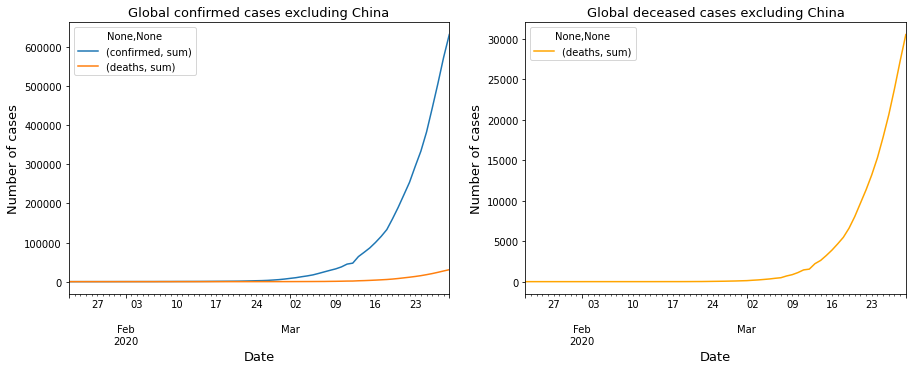

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

## Global Tendencies: China

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['China'], columns=['country_id']),
])

total_China = pipeline.apply(covid_df)

confirmed_total_date_China = total_China.groupby(['covid_date']).agg({'confirmed':['sum']})
fatalities_total_date_China = total_noChina.groupby(['covid_date']).agg({'deaths':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

Text(0.5, 0, 'Date')

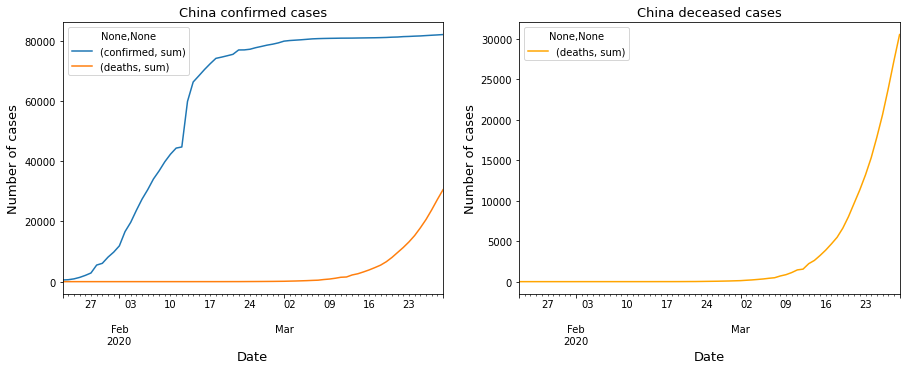

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

## Business-Related Tendencies: Operational Markets



### Overview

In [0]:
fcg_countries = {'Argentina': 'AR',
                 'Chile': 'CL',
                 'Colombia': 'CO',
                 'Mexico': 'MX',
                 'Nigeria': 'NG',
                 'Kenya': 'KE',
                 'Ghana': 'GH',
                 'Poland': 'PL', 
                 'United Arab Emirates': 'AE',
                 'India': 'IN',
                 'Indonesia': 'ID',
                 'Pakistan': 'PK'
                 }

pipeline = pdp.PdPipeline([
    pdp.ValKeep(fcg_countries.keys(), columns=['country_id']),
    pdp.MapColVals(['country_id'], fcg_countries)

])

covid_fcg_df = pipeline.apply(covid_df)

covid_containment_fcg_df = pipeline.apply(covid_containment_df)

covid_fcg_df.head(5)

,state,country_id,lat,long,covid_date,confirmed,deaths,recovered
402,NaN,AR,-38.4161,-63.6167,2020-01-22,0,0,0
403,NaN,AR,-38.4161,-63.6167,2020-01-23,0,0,0
404,NaN,AR,-38.4161,-63.6167,2020-01-24,0,0,0
405,NaN,AR,-38.4161,-63.6167,2020-01-25,0,0,0
406,NaN,AR,-38.4161,-63.6167,2020-01-26,0,0,0


In [0]:
fig = px.line(covid_fcg_df, x='covid_date', y='confirmed', color='country_id', title='Confirmed Cases of COVID-19 Evolution in the Markets')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Confirmed Cases')
fig.show()

In [0]:
fig = px.line(covid_fcg_df, x='covid_date', y='deaths', color='country_id', title='Death Cases of COVID-19 Evolution in the Markets')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Fatal Cases (Deaths)')
fig.show()

In [0]:
fig = px.line(covid_fcg_df, x='covid_date', y='recovered', color='country_id', title='Recovered Cases of COVID-19 Evolution in the Markets')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Recovery Cases')
fig.show()

In [0]:
px.bar(covid_fcg_df[['country_id', 'confirmed', 'deaths', 'recovered']].groupby(by=['country_id'], as_index=False).max().sort_values(by='confirmed'),
       x='country_id', y='confirmed', title='Total Current COVID-19 Confirmed Cases in the Markets', )

### Trends in Pakistan

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['PK'], columns=['country_id']),
])

covid_containment_pk_df = pipeline.apply(covid_containment_fcg_df)

temp = pipeline.apply(covid_fcg_df)

temp = temp.groupby('covid_date')['recovered', 'deaths', 'confirmed'].sum().reset_index()
temp = temp.melt(id_vars="covid_date", value_vars=['recovered', 'deaths', 'confirmed'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="covid_date", y="count", color='case',
             title='Cases over time: Pakistan', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cases')
fig.show()

### Log of Containment Measures in Pakistan

In [0]:
if covid_containment_pk_df.shape[0] > 0:
  display(covid_containment_pk_df)
else:
  print("No containment measures  documented by http://epidemicforecasting.org/containment")

No containment measures  documented by http://epidemicforecasting.org/containment


### Trends in Poland

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['PL'], columns=['country_id']),
])

covid_containment_pl_df = pipeline.apply(covid_containment_fcg_df)

temp = pipeline.apply(covid_fcg_df)

temp = temp.groupby('covid_date')['recovered', 'deaths', 'confirmed'].sum().reset_index()
temp = temp.melt(id_vars="covid_date", value_vars=['recovered', 'deaths', 'confirmed'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="covid_date", y="count", color='case',
             title='Cases over time: Poland', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cases')
fig.show()

### Log of Containment Measures in Poland



In [0]:
if covid_containment_pl_df.shape[0] > 0:
  display(covid_containment_pl_df)
else:
  print("No containment measures  documented by http://epidemicforecasting.org/containment")

,country_id,start_date,desc,keywords,source
418,PL,2020-02-19,On 19 February 12 people remained hospitalised...,"case reporting, source tracing",https://en.wikipedia.org/wiki/2020_coronavirus...
422,PL,2020-03-12,"All schools are closed (kindergardens, primary...","nursery schools closure, school closure, unive...",https://en.wikipedia.org/wiki/2020_coronavirus...
443,PL,2020-03-14,Activities of shopping malls limited,"business suspension, closure nonessential stores",https://wiadomosci.onet.pl/kraj/koronawirus-w-...
444,PL,2020-03-15,Religious assemblies of over 50 people banned.,religious activity limitations,https://www.onet.pl/?utm_source=pl.wikipedia.o...
445,PL,2020-03-14,Closure of borders for air and rail traffic.,international travel ban,NaN
450,PL,2020-03-04,The Ministry of Health informed about the firs...,first case,https://www.gov.pl/web/zdrowie/pierwszy-przypa...
451,PL,2020-03-15,Assemblies of over 50 people banned.,gathering of more than 50 people cancelled,https://www.onet.pl/?utm_source=pl.wikipedia.o...


### Trends in Chile

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['CL'], columns=['country_id']),
])

covid_containment_cl_df = pipeline.apply(covid_containment_fcg_df)

temp = pipeline.apply(covid_fcg_df)

temp = temp.groupby('covid_date')['recovered', 'deaths', 'confirmed'].sum().reset_index()
temp = temp.melt(id_vars="covid_date", value_vars=['recovered', 'deaths', 'confirmed'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="covid_date", y="count", color='case',
             title='Cases over time: Chile', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cases')
fig.show()

### Log of Containment Measures in Chile

In [0]:
if covid_containment_cl_df.shape[0] > 0:
  display(covid_containment_cl_df)
else:
  print("No containment measures documented by http://epidemicforecasting.org/containment")

No containment measures documented by http://epidemicforecasting.org/containment


### Trends in Indonesia

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['ID'], columns=['country_id']),
])

covid_containment_id_df = pipeline.apply(covid_containment_fcg_df)

temp = pipeline.apply(covid_fcg_df)

temp = temp.groupby('covid_date')['recovered', 'deaths', 'confirmed'].sum().reset_index()
temp = temp.melt(id_vars="covid_date", value_vars=['recovered', 'deaths', 'confirmed'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="covid_date", y="count", color='case',
             title='Cases over time: Indonesia', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cases')
fig.show()

**Note**: Indonesia is currently in the sad list of top 10 countries with the highest COVID-19-driven mortality ratio across the globe

### Log of Containment Measures in Indonesia

In [0]:
if covid_containment_id_df.shape[0] > 0:
  display(covid_containment_id_df)
else:
  print("No containment measures documented by http://epidemicforecasting.org/containment")

No containment measures documented by http://epidemicforecasting.org/containment


### Trends in India

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['IN'], columns=['country_id']),
])

covid_containment_in_df = pipeline.apply(covid_containment_fcg_df)

temp = pipeline.apply(covid_fcg_df)

temp = temp.groupby('covid_date')['recovered', 'deaths', 'confirmed'].sum().reset_index()
temp = temp.melt(id_vars="covid_date", value_vars=['recovered', 'deaths', 'confirmed'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="covid_date", y="count", color='case',
             title='Cases over time: India', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cases')
fig.show()

### Log of Containment Activities in India

In [0]:
if covid_containment_in_df.shape[0] > 0:
  display(covid_containment_in_df)
else:
  print("No containment measures documented by http://epidemicforecasting.org/containment")

No containment measures documented by http://epidemicforecasting.org/containment


## Business-Related Tendencies: Key Software Development Locations

In [0]:
sd_countries = {'Germany': 'DE',
                 'Sweden': 'SE',
                 'Ukraine': 'UA'
                 }

pipeline = pdp.PdPipeline([
    pdp.ValKeep(sd_countries.keys(), columns=['country_id']),
    pdp.MapColVals(['country_id'], sd_countries)

])

#countries_without_china = covid_df['country_id'].unique().tolist()
#display(countries_without_china)

covid_sd_df = pipeline.apply(covid_df)

covid_containment_sd_df = pipeline.apply(covid_containment_df)



### Trends in Germany

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['DE'], columns=['country_id']),
])

covid_containment_de_df = pipeline.apply(covid_containment_sd_df)

temp = pipeline.apply(covid_sd_df)

temp = temp.groupby('covid_date')['recovered', 'deaths', 'confirmed'].sum().reset_index()
temp = temp.melt(id_vars="covid_date", value_vars=['recovered', 'deaths', 'confirmed'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="covid_date", y="count", color='case',
             title='Cases over time: Germany', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cases')
fig.show()

### Containment measures in Germany

In [0]:
if covid_containment_de_df.shape[0] > 0:
  display(covid_containment_de_df)
else:
  print("No containment measures documented by http://epidemicforecasting.org/containment")

,country_id,start_date,desc,keywords,source
1,DE,2020-02-01,"102 German citizens and 26 relatives, all of w...","international traveller screening, traveller q...",https://www.tagesschau.de/inland/coronavirus-g...
486,DE,2020-03-16,"shut down the borders with France, Switzerland...",international travel ban,https://www.bbc.com/news/world-europe-51897069
489,DE,2020-03-13,14 of the 16 German federal states decided to ...,"nursery schools closure, school closure",https://www.zeit.de/news/2020-03/13/bayern-sch...
498,DE,2020-03-16,"Supermarkets, chemist's shops, banks, pet shop...","business suspension, closure nonessential stores",https://www.bundesregierung.de/breg-de/themen/...
499,DE,2020-03-17,that there should be no vacation trips in Germ...,outbound traveller ban,https://www.handelsblatt.com/politik/deutschla...
500,DE,2020-03-17,Deutsche Bahn decided to reduce its regional t...,domestic travel limitation,https://www.welt.de/wirtschaft/article20656592...
501,DE,2020-03-16,Germany declared a state of emergency,"emergency declaration, special management arra...",https://www.handelsblatt.com/politik/deutschla...
502,DE,2020-03-14,"Berlin, Schleswig-Holstein and Saarland closed...","business suspension, closure nonessential stores",https://www.spiegel.de/panorama/gesellschaft/c...
503,DE,2020-03-10,"ban on events with more than 1,000 participant...","activity ban, gathering of more than 1000 peop...",https://www.del.org/news/deutsche-eishockey-li...
540,DE,2020-03-18,Chancellor Angela Merkel urged all German citi...,public announcement,https://www.reuters.com/article/us-health-coro...


### Trends in Sweden

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['SE'], columns=['country_id']),
])

covid_containment_se_df = pipeline.apply(covid_containment_sd_df)

temp = pipeline.apply(covid_sd_df)

temp = temp.groupby('covid_date')['recovered', 'deaths', 'confirmed'].sum().reset_index()
temp = temp.melt(id_vars="covid_date", value_vars=['recovered', 'deaths', 'confirmed'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="covid_date", y="count", color='case',
             title='Cases over time: Sweden', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cases')
fig.show()

### Containment Measures in Sweden

In [0]:
if covid_containment_se_df.shape[0] > 0:
  display(covid_containment_se_df)
else:
  print("No containment measures documented by http://epidemicforecasting.org/containment")

,country_id,start_date,desc,keywords,source
61,SE,2020-03-20,SEK 1 billion to culture and sport as a result...,"economic stimulus, financial incentive",https://www.government.se/press-releases/2020/...
62,SE,2020-03-20,Increased loan facilities and credit guarantee...,"economic incentives, economic stimulus",https://www.government.se/press-releases/2020/...
63,SE,2020-03-19,Delivery of face masks to medical care service...,"hygiene enforcement, manufacturing capacity",https://www.government.se/articles/2020/03/s-w...
64,SE,2020-03-18,High schools and universities told to stop in...,"compulsory isolation, school closure, universi...",https://www.theguardian.com/world/2020/mar/12/...
65,SE,2020-03-18,The Government proposes that airlines be able ...,"economic stimulus, financial incentive",NaN
66,SE,2020-03-17,Temporary entry ban to the EU via Sweden. In r...,international travel ban,NaN
67,SE,2020-03-11,Stockholm region decided to only test hospital...,"new testing method commenced, testing criteria...",NaN
68,SE,2020-03-11,"The Swedish government passed a new law, tempo...","compulsory isolation, gathering of more than 5...",https://en.wikipedia.org/wiki/2020_coronavirus...
69,SE,2020-01-31,The first confirmed case of the pandemic of CO...,"case reporting, first case, source tracing",https://en.wikipedia.org/wiki/2020_coronavirus...
73,SE,NaT,NaN,NaN,NaN


### Trends in Ukraine

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep(['UA'], columns=['country_id']),
])

temp = pipeline.apply(covid_sd_df)

temp = temp.groupby('covid_date')['recovered', 'deaths', 'confirmed'].sum().reset_index()
temp = temp.melt(id_vars="covid_date", value_vars=['recovered', 'deaths', 'confirmed'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="covid_date", y="count", color='case',
             title='Cases over time: Ukraine', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cases')
fig.show()

## Global insights: Mortality and Recovery Rates¶
Mortality and Recovery rates as of the last date in the time series are worth seeing as well. It might have an insight for sure.

### Mortality Rates

In [0]:
cleaned_latest = covid_df[covid_df['covid_date'] == max(covid_df['covid_date'])]

flg = cleaned_latest.groupby('country_id')['confirmed', 'deaths', 'recovered'].sum().reset_index()

flg['mortalityRate'] = round((flg['deaths']/flg['confirmed'])*100, 2)
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('mortalityRate', ascending=False)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:10][::-1],
             x = 'mortalityRate', y = 'country_id', 
             title='Deaths per 100 Confirmed Cases', text='mortalityRate', height=800, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()



* San Marino and Italy within the most brutal of them all (however, both countries are trending down by this metric, which is a good news)
* Indonesia seems to be very dangerous places to get affected in Asia.
* The drop of mortality rates in Phillipes from previous days is encouraging.
* Death tolls in Italy have stormed up very high in the past few days. It is really worrying to see Italy suffering so much.
* Netherlands, and Spain being the most notable ones too.
* France recently moved off the top 10 list (by mortality rate)

**Note**: some other countries with poor medical system and unsufficient COVID-19 test system coverage may not display truly genuine charts in this view

### Countries with Lowest Mortality Rates

In [0]:
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('mortalityRate', ascending=True)[['country_id', 'confirmed','deaths']][:16]
temp.sort_values('confirmed', ascending=False)[['country_id', 'confirmed','deaths']][:20].style.background_gradient(cmap='Blues')

,country_id,confirmed,deaths
80,Israel,4247,15
32,Chile,2139,7
147,South Africa,1280,2
74,Iceland,1020,2
131,Qatar,634,1
116,New Zealand,514,1
92,Latvia,347,0
144,Slovakia,314,0
166,Uruguay,304,1
85,Kazakhstan,284,1


### Recovery Rates

In [0]:
flg['recoveryRate'] = round((flg['recovered']/flg['confirmed'])*100, 2)
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('recoveryRate', ascending=False)

fig = px.bar(temp.sort_values(by="recoveryRate", ascending=False)[:10][::-1],
             x = 'recoveryRate', y = 'country_id', 
             title='Recoveries per 100 Confirmed Cases', text='recoveryRate', height=800, orientation='h',
             color_discrete_sequence=['#2ca02c']
            )
fig.show()

* China can recover an estimated 91-92 out of every 100 that get affected. That's great and the numbers seem to increase for them everyday.
* One of the cruise ships (Diamand Princess) is also on the radar
* Bahrain as we can see are doing really well in terms of recovering.
* AE (within Operational Markets) seems to be in the relatively good shape, in terms of recovery
* Italy, Spain, US, France, UK and Germany... Where are they? Is that why they are in trouble now?

### Countries with the Worst Recovery Rates

In [0]:
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('recoveryRate', ascending=True)[['country_id', 'confirmed','recovered']][:20]
temp.sort_values('confirmed', ascending=False)[['country_id', 'confirmed','recovered']][:20].style.background_gradient(cmap='Oranges')

,country_id,confirmed,recovered
115,Netherlands,9819,6
130,Portugal,5170,43
121,Norway,4015,7
22,Brazil,3904,6
152,Sweden,3447,16
42,Czechia,2631,11
79,Ireland,2415,5
48,Ecuador,1823,3
129,Poland,1638,7
124,Panama,786,2


## History: How did it happen?

### Worldwide History: Confirmed Cases

In [0]:
formated_gdf = covid_df.groupby(['covid_date', 'country_id'])['confirmed', 'deaths'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="country_id", locationmode='country names', 
                     color="confirmed", size='size', hover_name="country_id", 
                     range_color= [0, 1500], 
                     projection="natural earth", animation_frame="covid_date", 
                     title='COVID-19: Spread Over Time', color_continuous_scale="portland")
fig.show()

* At the beginning (since the end of Jan 2020 as of the earliest data available) the disease seems to be only around China and its neighboring countries.

* However it quickly spread off to Europe, Autralia and even the US which is very interesting.

* Things seemed to be in fairly good mode for European locations even in mid February 2020.

* West Asia, especially Iran and Iraq, started to catch fire at the end of February 2020, along with Italy showing signs of the dread to come. South Korea and China were peaking at that moment.

* By March 5, 2020 the situation in Europe started to go out of the control. They could've have locked down right at that moment.

* The disease has taken away Africa and Americas too by early March, with alarm bells ringing loudly for the US with just over 500 cases.

* According to the data so far, USA, UK, Spain, Italy, Germany, France and the UK are in deep trouble. Next few days are crucial for how the disease develops around the world.

### Worldwide History: Deaths over Time

In [0]:
formated_gdf = covid_df.groupby(['covid_date', 'country_id'])['confirmed', 'deaths'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['deaths'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="country_id", locationmode='country names', 
                     color="deaths", size='size', hover_name="country_id", 
                     range_color= [0, 100], 
                     projection="natural earth", animation_frame="covid_date", 
                     title='COVID-19: Deaths Over Time', color_continuous_scale="peach")

fig.show()

The most interesting insights here are
  

*   China's relative steadiness since March
*   Europe's severe spreads.



### Europe's History: Confirmed Cases

In [0]:
formated_gdf = covid_df.groupby(['covid_date', 'country_id'])['confirmed', 'deaths', 'recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['confirmed'].pow(0.3) * 5

fig = px.scatter_geo(formated_gdf, locations="country_id", locationmode='country names', 
                     color="confirmed", size='size', hover_name="country_id", 
                     range_color= [0, 5000], 
                     projection="natural earth", animation_frame="covid_date", scope="europe",
                     title='COVID-19: Spread Over Time in EUROPE', color_continuous_scale="portland", height=800)
fig.show()

* According to the official dataset, it looks to be France who are first affected by the virus. 
* However, the data set lacks the hidden story about the remarkable football match in Bergamo that caused much stronger spread in Italy and Spain.
* Nothing bad has happened in Europe as long as mid February. End of February, Italy inflates considerably.
* Entire West Europe overshadowed by the virus by the mid of March 2020.

### Europe's History: Fatal Cases (Deaths)

In [0]:
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['deaths'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="country_id", locationmode='country names', 
                     color="deaths", size='size', hover_name="country_id", 
                     range_color= [0, 500], 
                     projection="natural earth", animation_frame="covid_date", scope="europe",
                     title='COVID-19: Deaths Over Time in EUROPE', color_continuous_scale="peach", height=800)
fig.show()

* At some point in Feb 2020, most of the EU countries seemed to have no active cases (except Italy).
* However, then we observe severe spread in Italy and other EU locations 
* The possible reason was the continual active spread in Italy under the lack of locking down public events and travel ban there

### Europe's History: Recovery Cases

In [0]:
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['recovered'].pow(0.3) * 3.5

fig = px.scatter_geo(formated_gdf, locations="country_id", locationmode='country names', 
                     color="recovered", size='size', hover_name="country_id", 
                     range_color= [0, 100], 
                     projection="natural earth", animation_frame="covid_date", scope="europe",
                     title='COVID-19: Recovered Cases Over Time in EUROPE', color_continuous_scale="greens", height=800)
fig.show()

# Feature Enrichment

In [0]:
# Basic clean-up and dates features

le = preprocessing.LabelEncoder()

covid_df_corr = covid_df.copy()
covid_df_corr['day_num'] = le.fit_transform(covid_df_corr.covid_date)
covid_df_corr['day'] = covid_df_corr['covid_date'].dt.day
covid_df_corr['month'] = covid_df_corr['covid_date'].dt.month
covid_df_corr['year'] = covid_df_corr['covid_date'].dt.year

# Fill null values given that we merged train-test datasets
covid_df_corr['state'].fillna("None", inplace=True)
covid_df_corr['confirmed'].fillna(0, inplace=True)
covid_df_corr['deaths'].fillna(0, inplace=True)
covid_df_corr['recovered'].fillna(0, inplace=True)

# lag and trend calculation
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = "Lag_" + column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df


ts = time.time()
covid_df_corr = calculate_lag(covid_df_corr, range(1,7), 'confirmed')
covid_df_corr = calculate_lag(covid_df_corr, range(1,7), 'deaths')
covid_df_corr = calculate_lag(covid_df_corr, range(1,7), 'recovered')
covid_df_corr = calculate_trend(covid_df_corr, range(1,7), 'confirmed')
covid_df_corr = calculate_trend(covid_df_corr, range(1,7), 'deaths')
covid_df_corr = calculate_trend(covid_df_corr, range(1,7), 'recovered')
covid_df_corr.replace([np.inf, -np.inf], 0, inplace=True)
covid_df_corr.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.2513248920440674


## Correlation of the basic pandemic features 

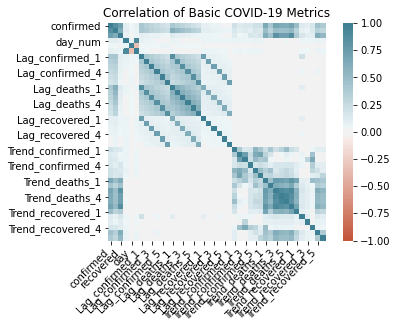

In [0]:
# Booking rate correlation to COVID-19 indicators: AE perspective (other countries have too little data since COVID-19 hickup to consider for the corr analysis)
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({'state',	'country_id',	'lat',	'long',	'covid_date', 'year'})
])


data = corr_transform.apply(covid_df_corr)
corr = data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation of Basic COVID-19 Metrics')
ax

In [0]:
display(corr)

,confirmed,deaths,recovered,day_num,day,month,Lag_confirmed_1,Lag_confirmed_2,Lag_confirmed_3,Lag_confirmed_4,Lag_confirmed_5,Lag_confirmed_6,Lag_deaths_1,Lag_deaths_2,Lag_deaths_3,Lag_deaths_4,Lag_deaths_5,Lag_deaths_6,Lag_recovered_1,Lag_recovered_2,Lag_recovered_3,Lag_recovered_4,Lag_recovered_5,Lag_recovered_6,Trend_confirmed_1,Trend_confirmed_2,Trend_confirmed_3,Trend_confirmed_4,Trend_confirmed_5,Trend_confirmed_6,Trend_deaths_1,Trend_deaths_2,Trend_deaths_3,Trend_deaths_4,Trend_deaths_5,Trend_deaths_6,Trend_recovered_1,Trend_recovered_2,Trend_recovered_3,Trend_recovered_4,Trend_recovered_5,Trend_recovered_6
confirmed,1.000000,0.860127,0.727249,0.108582,0.043990,0.083861,0.408843,0.356044,0.305488,0.263915,0.217743,0.185453,0.400119,0.343711,0.298249,0.257855,0.213760,0.180485,0.085612,0.081007,0.064125,0.056047,0.038925,0.032707,0.201812,0.128351,0.150016,0.148943,0.209793,0.209945,0.649477,0.428639,0.683960,0.644010,0.637590,0.707440,0.488129,0.119055,0.086512,0.161198,0.448510,0.396070
deaths,0.860127,1.000000,0.629503,0.087874,0.039787,0.066203,0.408157,0.371089,0.325735,0.288423,0.252299,0.221583,0.607608,0.536108,0.467973,0.407596,0.350208,0.299578,0.108100,0.105709,0.083999,0.071812,0.060449,0.051916,0.151983,0.112263,0.132286,0.102189,0.173880,0.154915,0.485049,0.320484,0.507747,0.473914,0.476693,0.526191,0.319310,0.084583,0.054537,0.155505,0.338425,0.296829
recovered,0.727249,0.629503,1.000000,0.070748,0.014343,0.060783,0.096757,0.084285,0.076697,0.071196,0.051822,0.046212,0.120004,0.099435,0.091672,0.082312,0.063012,0.053430,0.047750,0.048074,0.039991,0.039456,0.018805,0.017133,0.124157,0.042424,0.069236,0.156523,0.147954,0.182076,0.628746,0.456301,0.834823,0.721614,0.718755,0.863154,0.383362,0.165418,0.115348,0.111368,0.618904,0.532706
day_num,0.108582,0.087874,0.070748,1.000000,0.068721,0.910618,0.085108,0.065983,0.049383,0.034296,0.021998,0.011999,0.067348,0.051387,0.037585,0.024881,0.014393,0.006091,0.064643,0.059913,0.055924,0.052621,0.049956,0.047693,0.053499,0.063782,0.055839,0.054464,0.072959,0.061408,0.031121,0.036695,0.026999,0.027802,0.039369,0.035210,0.005419,0.049644,0.045633,0.048855,0.071348,0.067196
day,0.043990,0.039787,0.014343,0.068721,1.000000,-0.349159,0.043575,0.043898,0.044915,0.046537,0.048851,0.051706,0.039049,0.039171,0.039870,0.041007,0.042693,0.044901,0.014099,0.014120,0.014334,0.014734,0.015309,0.016005,0.023153,0.021804,0.015683,-0.000665,0.029703,0.014089,0.005677,0.011145,-0.003665,-0.000350,0.007062,0.001927,-0.000592,0.004964,0.002229,0.020983,0.007435,0.004691
month,0.083861,0.066203,0.060783,0.910618,-0.349159,1.000000,0.062219,0.044311,0.028460,0.013762,0.001368,-0.009114,0.047433,0.032547,0.019428,0.007146,-0.003305,-0.011941,0.055212,0.050807,0.047011,0.043774,0.041058,0.038665,0.040739,0.051143,0.046090,0.051446,0.056370,0.052029,0.026595,0.029718,0.026713,0.026012,0.033860,0.032096,0.004824,0.044165,0.041936,0.037221,0.063861,0.061211
Lag_confirmed_1,0.408843,0.408157,0.096757,0.085108,0.043575,0.062219,1.000000,0.408843,0.356044,0.305488,0.263915,0.217743,0.860127,0.400119,0.343711,0.298249,0.257855,0.213760,0.727249,0.085612,0.081007,0.064125,0.056047,0.038925,-0.006450,-0.002322,-0.005715,0.002797,-0.004003,-0.003776,-0.005919,-0.002935,-0.005439,-0.004852,-0.003870,-0.003613,-0.004241,0.203324,-0.003471,0.002677,0.013786,0.013410
Lag_confirmed_2,0.356044,0.371089,0.084285,0.065983,0.043898,0.044311,0.408843,1.000000,0.408843,0.356044,0.305488,0.263915,0.408157,0.860127,0.400119,0.343711,0.298249,0.257855,0.096757,0.727249,0.085612,0.081007,0.064125,0.056047,-0.003190,-0.006469,-0.006070,-0.006452,-0.002732,-0.001832,0.004779,-0.000795,0.005602,0.005977,0.005765,0.007955,0.005035,-0.009298,-0.003105,-0.002583,0.013425,0.013926
Lag_confirmed_3,0.305488,0.325735,0.076697,0.049383,0.044915,0.028460,0.356044,0.408843,1.000000,0.408843,0.356044,0.305488,0.371089,0.408157,0.860127,0.400119,0.343711,0.298249,0.084285,0.096757,0.727249,0.085612,0.081007,0.064125,-0.002468,-0.

# COVID-19 and National Economies / Healthcare / Demographics / Cultural Attitudes


correlation of COVID-19 pandemic metrics (confirmed, deaths, recovered) with macroeconomic params and wealness/cultural attitude in different countries (to seee if the significant impact of culture/national economies on the coronavirus spread can be confirmed)

## COVID-19 and Population Forecast Data 2020 from Worldometers

Load Population Forecast Data 2020 from Worldometers:

In [0]:
population_2020_path = base_dataset_folder + '/population-by-country-2020/population_by_country_2020.csv'

# Load countries data file
world_population_raw = pd.read_csv(population_2020_path)

world_population_raw.head(5)

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [0]:
# Prepare country name transformation
country_names = world_population_raw['Country (or dependency)'].unique().tolist()

# Create a zip object from two lists
zipbObj = zip(country_names, country_names)
 
# Create a dictionary from zip object
dictOfCountries = dict(zipbObj)

# overwrite a mapping for 'United States'
dictOfCountries['United States'] = 'US'
# Kosovo and Cruise Ship manually
dictOfCountries['Kosovo'] = 'Kosovo'
dictOfCountries['Diamond Princess'] = 'Diamond Princess'

# Add Kosovo and Cruise Ship data manually
# https://en.wikipedia.org/wiki/Demographics_of_Kosovo
# https://www.indexmundi.com/kosovo/#Demographics
# https://en.wikipedia.org/wiki/Diamond_Princess_(ship)
df1 = pd.DataFrame({'Country (or dependency)':['Kosovo','Diamond Princess'],
                        'Population (2020)':[1793000,3711],
                        'Yearly Change':[0.64,0],
                        'Net Change':[1147,0],
                        'Density (P/Km²)':[165,26],
                        'Land Area (Km²)':[10887,141],
                        'Migrants (net)':[-7340,0],
                        'Fert. Rate':[2.09,0],
                        'Med. Age':[30,62],
                        'Urban Pop %':['65%','100%'],
                        'World Share':[0.02,0.00]})
    
world_population_raw = world_population_raw.append(df1)

pipeline = pdp.PdPipeline([
    pdp.ColDrop(['Fert. Rate', 'Migrants (net)', 'Yearly Change', 'World Share']),
    pdp.ColRename({'Country (or dependency)': 'country_id', 
                   'Population (2020)': 'pop_2020', 
                   'Net Change': 'net_growth_from_2019', 
                   'Density (P/Km²)': 'pop_density',
                   'Land Area (Km²)': 'land_area',
                   'Med. Age': 'med_age',
                   'Urban Pop %': 'urban_pop_ratio'
                   }),
    pdp.MapColVals(['country_id'], dictOfCountries)
])

world_population = pipeline.apply(world_population_raw)

# Remove the % character from Urban Pop values
world_population['urban_pop_ratio'] = world_population['urban_pop_ratio'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['urban_pop_ratio']=='N.A.', 'urban_pop_ratio'] = int(world_population.loc[world_population['urban_pop_ratio']!='N.A.', 'urban_pop_ratio'].mode()[0])
world_population['urban_pop_ratio'] = world_population['urban_pop_ratio'].astype('int16')
world_population.loc[world_population['med_age']=='N.A.', 'med_age'] = int(world_population.loc[world_population['med_age']!='N.A.', 'med_age'].mode()[0])
world_population['med_age'] = world_population['med_age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)



Cleaned country details dataset


,country_id,pop_2020,net_growth_from_2019,pop_density,land_area,med_age,urban_pop_ratio
0,China,1439323776,5540090,153,9388211,38,61
1,India,1380004385,13586631,464,2973190,28,35
2,US,331002651,1937734,36,9147420,38,83
3,Indonesia,273523615,2898047,151,1811570,30,56
4,Pakistan,220892340,4327022,287,770880,23,35
...,...,...,...,...,...,...,...
232,Niue,1626,11,6,260,19,46
233,Tokelau,1357,17,136,10,19,0
234,Holy See,801,2,2003,0,19,57
0,Kosovo,1793000,1147,165,10887,30,65


Now we will merge world_population and the slice of covid_df for the latest date as well as calculate essential relative metrics

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ValKeep([covid_end_date], columns = ['covid_date'])              
])
# countries_without_china, columns=['country_id']
covid_latest_date_df = pipeline.apply(covid_df)

#join
all_demo_data = covid_latest_date_df.merge(world_population, on='country_id', how='left')

pipe_calc = pdp.PdPipeline([
    pdp.ApplyToRows(lambda row: (row['deaths']/row['confirmed']), 'mortality_rate'),
    pdp.ApplyToRows(lambda row: (row['recovered']/row['confirmed']), 'recovery_rate'),
    pdp.ApplyToRows(lambda row: (row['confirmed']/row['pop_2020']), 'confirmed2pop'),
    pdp.ApplyToRows(lambda row: (row['net_growth_from_2019']/row['pop_2020']), 'pop_growth'),                 
])

# calculate ratio attributes
all_demo_data = pipe_calc.apply(all_demo_data)

display(all_demo_data)

,state,country_id,lat,long,covid_date,confirmed,deaths,recovered,pop_2020,net_growth_from_2019,pop_density,land_area,med_age,urban_pop_ratio,mortality_rate,recovery_rate,confirmed2pop,pop_growth
0,NaN,Afghanistan,33.0000,65.0000,2020-03-29,120,4,2,38928346.0,886592.0,60.0,652860.0,18.0,25.0,0.033333,0.016667,3.082587e-06,0.022775
1,NaN,Albania,41.1533,20.1683,2020-03-29,212,10,33,2877797.0,-3120.0,105.0,27400.0,36.0,63.0,0.047170,0.155660,7.366746e-05,-0.001084
2,NaN,Algeria,28.0339,1.6596,2020-03-29,511,31,31,43851044.0,797990.0,18.0,2381740.0,29.0,73.0,0.060665,0.060665,1.165309e-05,0.018198
3,NaN,Andorra,42.5063,1.5218,2020-03-29,334,6,1,77265.0,123.0,164.0,470.0,19.0,88.0,0.017964,0.002994,4.322785e-03,0.001592
4,NaN,Angola,-11.2027,17.8739,2020-03-29,7,2,0,32866272.0,1040977.0,26.0,1246700.0,17.0,67.0,0.285714,0.000000,2.129843e-07,0.031673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,NaN,Venezuela,6.4238,-66.5897,2020-03-29,119,2,39,28435940.0,-79889.0,32.0,882050.0,30.0,57.0,0.016807,0.327731,4.184845e-06,-0.002809
231,NaN,Vietnam,16.0000,108.0000,2020-03-29,188,0,25,97338579.0,876473.0,314.0,310070.0,32.0,38.0,0.000000,0.132979,1.931403e-06,0.009004
232,NaN,West Bank and Gaza,31.9522,35.2332,2020-03-29,109,1,18,NaN,NaN,NaN,NaN,NaN,NaN,0.009174,0.165138,NaN,NaN
233,NaN,Zambia,-15.4167,28.2833,2020-03-29,29,0,0,18383955.0,522925.0,25.0,743390.0,18.0,45.0,0.000000,0.000000,1.577463e-06,0.028445


Now we will prepare subset of metrics for correlation analysis

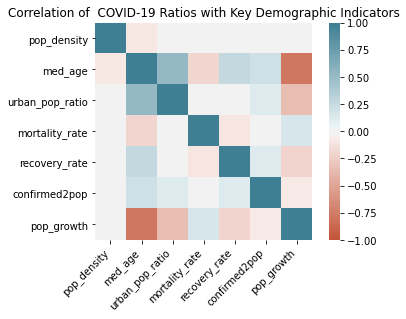

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ColDrop(['state', 'country_id', 'lat', 'long', 'covid_date',
                 'confirmed',	'deaths',	'recovered',	'pop_2020',	
                 'net_growth_from_2019',
                 'land_area'])
])

all_demo_data_corr = pipeline.apply(all_demo_data)

corr = all_demo_data_corr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation of  COVID-19 Ratios with Key Demographic Indicators')
ax

In [0]:
display(corr)

,pop_density,med_age,urban_pop_ratio,mortality_rate,recovery_rate,confirmed2pop,pop_growth
pop_density,1.000000,-0.079724,-0.030877,-0.039120,-0.017299,0.119581,-0.019413
med_age,-0.079724,1.000000,0.515920,-0.152535,0.263876,-0.078503,-0.792633
urban_pop_ratio,-0.030877,0.515920,1.000000,-0.032255,-0.046975,0.154029,-0.340590
mortality_rate,-0.039120,-0.152535,-0.032255,1.000000,-0.089074,0.051515,0.111679
recovery_rate,-0.017299,0.263876,-0.046975,-0.089074,1.000000,-0.109144,-0.219653
confirmed2pop,0.119581,-0.078503,0.154029,0.051515,-0.109144,1.000000,-0.125630
pop_growth,-0.019413,-0.792633,-0.340590,0.111679,-0.219653,-0.125630,1.000000


The key findings are as follows

* There is a certain negative correlation between the ratio of national population growth in a country and the recovery rate from COVID-19
* COVID-19 recovery rate has a certain positive correlation with the medium age of a national population 
* COVID-19 mortality rate has a certain negative correlation with the medium age of a national population 
* % of confirmed COVID-19 cases among the national population has a certain positive correlation with the density of population and % of urban population in a country

## COVID-19 and WHO Obesity Index

Load WHO Obesity Index data

In [0]:
who_obesity_2016_path = base_dataset_folder + '/who-obesity-by-country-2016/WHO_obesityByCountry_2016.csv'

# Load countries data file
who_obesity_raw = pd.read_csv(who_obesity_2016_path)

who_obesity_raw.head(5)

,Unnamed: 0,Both.sexes,Male,Female
0,Afghanistan,4.5,2.7,6.2
1,Albania,22.3,21.9,22.8
2,Algeria,26.6,19.4,34.0
3,Andorra,28.0,27.9,28.1
4,Angola,6.8,3.5,10.0


Now we will transform the raw obesity dataframe to prepare it to merge with  COVID-19 pandemic metrics

In [0]:
# Prepare country name transformation
country_names = who_obesity_raw['Unnamed: 0'].unique().tolist()

# Create a zip object from two lists
zipbObj = zip(country_names, country_names)
 
# Create a dictionary from zip object
dictOfCountries = dict(zipbObj)

# overwrite a mapping for the countries with different names in WHO Obesity and COVID-19 datasets
dictOfCountries['United States of America'] = 'US'
dictOfCountries['Côte d\'Ivoire'] = 'Cote d\'Ivoire'
dictOfCountries['United Kingdom of Great Britain and Northern Ireland'] = 'United Kingdom'
dictOfCountries['Republic of North Macedonia'] = 'North Macedonia'
dictOfCountries['Taiwan'] = 'Taiwan*'
dictOfCountries['Republic of Korea'] = 'Korea, South'
dictOfCountries['Congo'] = 'Congo (Brazzaville)'
dictOfCountries['Democratic Republic of the Congo'] = 'Congo (Kinshasa)'
dictOfCountries['United Republic of Tanzania'] = 'Tanzania'
dictOfCountries['Viet Nam'] = 'Vietnam'
dictOfCountries['Republic of Moldova'] = 'Moldova'
dictOfCountries['Iran (Islamic Republic of)'] = 'Iran'
dictOfCountries['Brunei Darussalam'] = 'Brunei'
dictOfCountries['Russian Federation'] = 'Russia'
dictOfCountries['Venezuela (Bolivarian Republic of)'] = 'Venezuela'
dictOfCountries['Bolivia (Plurinational State of)'] = 'Bolivia'
dictOfCountries['Lao People\'s Democratic Republic'] = 'Laos'
dictOfCountries['Syrian Arab Republic'] = 'Syria'
dictOfCountries['Liechtenstein'] = 'Liechtenstein'
 

pipeline = pdp.PdPipeline([
    pdp.ColRename({'Unnamed: 0': 'country_id', 
                   'Both.sexes': 'combined_obesity', 
                   'Male': 'male_obesity', 
                   'Female': 'female_obesity'}),
    pdp.MapColVals(['country_id'], dictOfCountries)
])

who_obesity_df = pipeline.apply(who_obesity_raw)

display(who_obesity_df)


,country_id,combined_obesity,male_obesity,female_obesity
0,Afghanistan,4.5,2.7,6.2
1,Albania,22.3,21.9,22.8
2,Algeria,26.6,19.4,34.0
3,Andorra,28.0,27.9,28.1
4,Angola,6.8,3.5,10.0
...,...,...,...,...
190,Venezuela,25.2,22.1,28.3
191,Vietnam,2.1,1.6,2.6
192,Yemen,14.1,9.9,18.2
193,Zambia,6.5,3.0,10.0


Now we will merge *covid_latest_date_df* and the pre-processed/transformed WHO obesity dataframe

In [0]:
#join
all_obesity_data = covid_latest_date_df.merge(who_obesity_df, on='country_id', how='left')

pipe_calc = pdp.PdPipeline([
    pdp.ApplyToRows(lambda row: (row['deaths']/row['confirmed']), 'mortality_rate'),
    pdp.ApplyToRows(lambda row: (row['recovered']/row['confirmed']), 'recovery_rate'),                
])

# calculate ratio attributes
all_obesity_data = pipe_calc.apply(all_obesity_data)


all_obesity_data.head(5)

,state,country_id,lat,long,covid_date,confirmed,deaths,recovered,combined_obesity,male_obesity,female_obesity,mortality_rate,recovery_rate
0,NaN,Afghanistan,33.0000,65.0000,2020-03-28,110,4,2,4.5,2.7,6.2,0.036364,0.018182
1,NaN,Albania,41.1533,20.1683,2020-03-28,197,10,31,22.3,21.9,22.8,0.050761,0.157360
2,NaN,Algeria,28.0339,1.6596,2020-03-28,454,29,31,26.6,19.4,34.0,0.063877,0.068282
3,NaN,Andorra,42.5063,1.5218,2020-03-28,308,3,1,28.0,27.9,28.1,0.009740,0.003247
4,NaN,Angola,-11.2027,17.8739,2020-03-28,5,0,0,6.8,3.5,10.0,0.000000,0.000000


Now we will prepare subset of metrics for correlation analysis

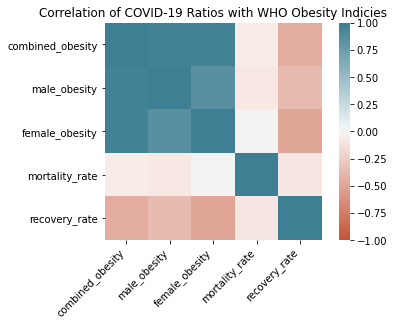

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ColDrop(['state', 'country_id', 'lat', 'long', 'covid_date',
                 'confirmed',	'deaths',	'recovered'])
])

all_obesity_data_corr = pipeline.apply(all_obesity_data)

corr = all_obesity_data_corr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation of COVID-19 Ratios with WHO Obesity Indicies')
ax

In [0]:
display(corr)

,combined_obesity,male_obesity,female_obesity,mortality_rate,recovery_rate
combined_obesity,1.000000,0.958254,0.964280,-0.027724,-0.455346
male_obesity,0.958254,1.000000,0.851028,-0.067818,-0.363707
female_obesity,0.964280,0.851028,1.000000,0.006659,-0.496061
mortality_rate,-0.027724,-0.067818,0.006659,1.000000,-0.086992
recovery_rate,-0.455346,-0.363707,-0.496061,-0.086992,1.000000


We find that 

* mortality rate  is not correlated with any of the obesity metrics
* recovery rare has quite strong negative correlation with *female_obesity* as well as slightly less strong negative correlation with *combined_obesity*) 

## COVID-19 and WHO Overweight Index

Load WHO Overweight Index data

In [0]:
who_overweight_2016_path = base_dataset_folder + '/who-overweight-by-country-2016/WHO_overweightByCountry_2016.csv'

# Load WHO overweight data file
who_overweight_raw = pd.read_csv(who_overweight_2016_path)

who_overweight_raw.head(5)

,Unnamed: 0,Both.sexes,Male,Female
0,Afghanistan,19.7,17.1,22.2
1,Albania,58.7,64.9,52.8
2,Algeria,60.7,56.7,64.8
3,Andorra,68.1,74.5,61.9
4,Angola,23.9,17.2,30.4


Now we will transform the raw overweight dataframe to prepare it to merge with  COVID-19 pandemic metrics

In [0]:
# Prepare country name transformation
country_names = who_overweight_raw['Unnamed: 0'].unique().tolist()

# Create a zip object from two lists
zipbObj = zip(country_names, country_names)
 
# Create a dictionary from zip object
dictOfCountries = dict(zipbObj)

# overwrite a mapping for the countries with different names in WHO Obesity and COVID-19 datasets
dictOfCountries['United States of America'] = 'US'
dictOfCountries['Côte d\'Ivoire'] = 'Cote d\'Ivoire'
dictOfCountries['United Kingdom of Great Britain and Northern Ireland'] = 'United Kingdom'
dictOfCountries['Republic of North Macedonia'] = 'North Macedonia'
dictOfCountries['Taiwan'] = 'Taiwan*'
dictOfCountries['Republic of Korea'] = 'Korea, South'
dictOfCountries['Congo'] = 'Congo (Brazzaville)'
dictOfCountries['Democratic Republic of the Congo'] = 'Congo (Kinshasa)'
dictOfCountries['United Republic of Tanzania'] = 'Tanzania'
dictOfCountries['Viet Nam'] = 'Vietnam'
dictOfCountries['Republic of Moldova'] = 'Moldova'
dictOfCountries['Iran (Islamic Republic of)'] = 'Iran'
dictOfCountries['Brunei Darussalam'] = 'Brunei'
dictOfCountries['Russian Federation'] = 'Russia'
dictOfCountries['Venezuela (Bolivarian Republic of)'] = 'Venezuela'
dictOfCountries['Bolivia (Plurinational State of)'] = 'Bolivia'
dictOfCountries['Lao People\'s Democratic Republic'] = 'Laos'
dictOfCountries['Syrian Arab Republic'] = 'Syria'
dictOfCountries['Liechtenstein'] = 'Liechtenstein'
 

pipeline = pdp.PdPipeline([
    pdp.ColRename({'Unnamed: 0': 'country_id', 
                   'Both.sexes': 'combined_overweight', 
                   'Male': 'male_overweight', 
                   'Female': 'female_overweight'}),
    pdp.MapColVals(['country_id'], dictOfCountries)
])

who_overweight_df = pipeline.apply(who_overweight_raw)

display(who_overweight_df)

,country_id,combined_overweight,male_overweight,female_overweight
0,Afghanistan,19.7,17.1,22.2
1,Albania,58.7,64.9,52.8
2,Algeria,60.7,56.7,64.8
3,Andorra,68.1,74.5,61.9
4,Angola,23.9,17.2,30.4
...,...,...,...,...
190,Venezuela,62.6,62.0,63.2
191,Vietnam,18.3,15.9,20.5
192,Yemen,42.3,38.3,46.3
193,Zambia,23.9,16.7,31.0


Now we will merge *covid_latest_date_df* and the pre-processed/transformed WHO overweight dataframe

In [0]:
#join
all_overweight_data = covid_latest_date_df.merge(who_overweight_df, on='country_id', how='left')

pipe_calc = pdp.PdPipeline([
    pdp.ApplyToRows(lambda row: (row['deaths']/row['confirmed']), 'mortality_rate'),
    pdp.ApplyToRows(lambda row: (row['recovered']/row['confirmed']), 'recovery_rate'),                
])

# calculate ratio attributes
all_overweight_data = pipe_calc.apply(all_overweight_data)


all_overweight_data.head(5)

,state,country_id,lat,long,covid_date,confirmed,deaths,recovered,combined_overweight,male_overweight,female_overweight,mortality_rate,recovery_rate
0,NaN,Afghanistan,33.0000,65.0000,2020-03-28,110,4,2,19.7,17.1,22.2,0.036364,0.018182
1,NaN,Albania,41.1533,20.1683,2020-03-28,197,10,31,58.7,64.9,52.8,0.050761,0.157360
2,NaN,Algeria,28.0339,1.6596,2020-03-28,454,29,31,60.7,56.7,64.8,0.063877,0.068282
3,NaN,Andorra,42.5063,1.5218,2020-03-28,308,3,1,68.1,74.5,61.9,0.009740,0.003247
4,NaN,Angola,-11.2027,17.8739,2020-03-28,5,0,0,23.9,17.2,30.4,0.000000,0.000000


Now we will prepare subset of metrics for correlation analysis

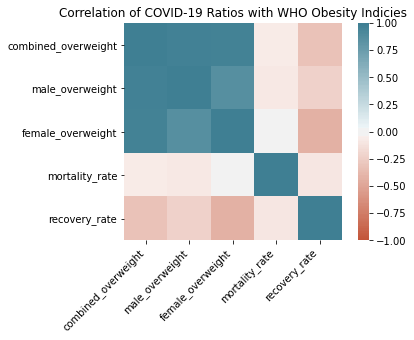

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ColDrop(['state', 'country_id', 'lat', 'long', 'covid_date',
                 'confirmed',	'deaths',	'recovered'])
])

all_overweight_data_corr = pipeline.apply(all_overweight_data)

corr = all_overweight_data_corr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation of COVID-19 Ratios with WHO Obesity Indicies')
ax

In [0]:
display(corr)

,combined_overweight,male_overweight,female_overweight,mortality_rate,recovery_rate
combined_overweight,1.000000,0.973526,0.952704,-0.041476,-0.324937
male_overweight,0.973526,1.000000,0.858185,-0.070423,-0.220445
female_overweight,0.952704,0.858185,1.000000,-0.000269,-0.438970
mortality_rate,-0.041476,-0.070423,-0.000269,1.000000,-0.086992
recovery_rate,-0.324937,-0.220445,-0.438970,-0.086992,1.000000


We find that 

* mortality rate  is not correlated with any of the overweight metrics
* recovery rare has quite strong negative correlation with *female_overweight* (as well as a moderate correlation with *combined_overweight* )

# COVID and Air Pollution Metrics

We will load air pollution data set first

In [0]:
air_pollution_data_path = base_dataset_folder + '/pollution-by-country-for-covid19-analysis/region_pollution.csv'

# Load countries data file
air_pollution_raw = pd.read_csv(air_pollution_data_path)

air_pollution_raw.head(5)

,Region,Outdoor Pollution (deaths per 100000),Indoor Pollution (deaths per 100000)
0,Afghanistan,51.548287,134.993753
1,Albania,22.641276,18.280754
2,Algeria,44.028297,0.191767
3,Andorra,15.797475,0.165664
4,Antigua and Barbuda,30.920300,1.435594


Now we will transform the raw data (with the metrics of death rates due to indoor and outdoor pollution) into the format ready to merge with COVID-19 pandemic metrics

In [0]:
# Prepare country name transformation
country_names = air_pollution_raw['Region'].unique().tolist()

# Create a zip object from two lists
zipbObj = zip(country_names, country_names)
 
# Create a dictionary from zip object
dictOfCountries = dict(zipbObj)

# overwrite a mapping for the countries with different names in WHO Obesity and COVID-19 datasets
dictOfCountries['United States of America'] = 'US'

pipeline = pdp.PdPipeline([
    pdp.ColRename({'Region': 'country_id', 
                   'Outdoor Pollution (deaths per 100000)': 'outdoor_poll_death_rate', 
                   'Indoor Pollution (deaths per 100000)': 'indoor_poll_death_rate'}),
    pdp.MapColVals(['country_id'], dictOfCountries)
])

air_pollution_df = pipeline.apply(air_pollution_raw)

display(air_pollution_df)

,country_id,outdoor_poll_death_rate,indoor_poll_death_rate
0,Afghanistan,51.548287,134.993753
1,Albania,22.641276,18.280754
2,Algeria,44.028297,0.191767
3,Andorra,15.797475,0.165664
4,Antigua and Barbuda,30.920300,1.435594
...,...,...,...
158,Uruguay,19.351625,1.257980
159,Uzbekistan,82.001421,23.633507
160,Venezuela,34.553983,0.472981
161,Vietnam,35.434645,25.636264


Now we will merge *covid_latest_date_df* and the pre-processed/transformed pollution-driven death rates dataframe

In [0]:
#join
all_air_pollution_data = covid_latest_date_df.merge(air_pollution_df, on='country_id', how='left')

pipe_calc = pdp.PdPipeline([
    pdp.ApplyToRows(lambda row: (row['deaths']/row['confirmed']), 'mortality_rate'),
    pdp.ApplyToRows(lambda row: (row['recovered']/row['confirmed']), 'recovery_rate'),                
])

# calculate ratio attributes
all_air_pollution_data = pipe_calc.apply(all_air_pollution_data)


all_air_pollution_data.head(5)

,state,country_id,lat,long,covid_date,confirmed,deaths,recovered,outdoor_poll_death_rate,indoor_poll_death_rate,mortality_rate,recovery_rate
0,NaN,Afghanistan,33.0000,65.0000,2020-03-28,110,4,2,51.548287,134.993753,0.036364,0.018182
1,NaN,Albania,41.1533,20.1683,2020-03-28,197,10,31,22.641276,18.280754,0.050761,0.157360
2,NaN,Algeria,28.0339,1.6596,2020-03-28,454,29,31,44.028297,0.191767,0.063877,0.068282
3,NaN,Andorra,42.5063,1.5218,2020-03-28,308,3,1,15.797475,0.165664,0.009740,0.003247
4,NaN,Angola,-11.2027,17.8739,2020-03-28,5,0,0,NaN,NaN,0.000000,0.000000


Now we will prepare the subset of data for correlation analysis

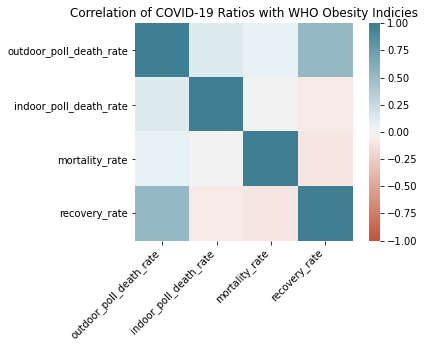

In [0]:
pipeline = pdp.PdPipeline([
    pdp.ColDrop(['state', 'country_id', 'lat', 'long', 'covid_date',
                 'confirmed',	'deaths',	'recovered'])
])

all_air_pollution_data_corr = pipeline.apply(all_air_pollution_data)

corr = all_air_pollution_data_corr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation of COVID-19 Ratios with WHO Obesity Indicies')
ax

In [0]:
display(corr)

,outdoor_poll_death_rate,indoor_poll_death_rate,mortality_rate,recovery_rate
outdoor_poll_death_rate,1.000000,0.119642,0.075263,0.527604
indoor_poll_death_rate,0.119642,1.000000,0.023163,-0.064933
mortality_rate,0.075263,0.023163,1.000000,-0.089074
recovery_rate,0.527604,-0.064933,-0.089074,1.000000


We find a weird inference (most probably) - there is quite a strong correlation between *recovery_rate* and *outdoor_poll_death_rate*. It may be related to the fact of the better industrial  development of countries with higher outbound pollution-driven deaths rate (and thus their ability to better cope with COVID-91)

# COVID-19 and Weather

This section will cover the analysis of correlation of COVID-19 pandemic metrics (confirmed, deaths, recovered) with weather parameters (to check the hypothesis of COVID-19 to be weather-sensitive, like influenza viruses)

TBD

# COVID-9 Forecast: Confirmed and Fatal Cases in the next 7 days

TBD

# Data Sources



1.   JHU CoronaVirus Dataset: https://github.com/CSSEGISandData/COVID-19
2.   COVID-19 containment and mitigation measures (https://www.kaggle.com/paultimothymooney/covid-19-containment-and-mitigation-measures/), using data from http://epidemicforecasting.org/containment
3.   Popolation forecasts 2020 (https://www.kaggle.com/tanuprabhu/population-by-country-2020, scrapped data from https://www.worldometers.info/world-population/population-by-country/, based on the latest United Nations Population Division estimates
4.   TBD



